# Simulate Lenses
for a sample of LRGs from the catalog,
- get their logmass, targetid, & healpixel information
- get the range of source galaxy redshifts for a given einstein angle for that galaxy's mass
- get the galaxy's spectrum from the healpix files
- get another galaxy within the redshift range in the same healpixel
- take the weighted sum of the fluxes

In [1]:
from astropy.table import Table, join, hstack, vstack, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.wcs import WCS

from desitarget.targets import desi_mask
from desispec.io import read_spectra
from desispec.coaddition import coadd, coadd_cameras
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### catalog initialization
open the catalog, isolate the LRGs, and do some cleanup steps

In [2]:
redux = 'guadalupe'

# note- healpix catalog not available for Iron yet, use Guadalupe or earlier
catalog = Table.read(f'/global/cfs/cdirs/desi/science/gqp/stellar_masses/{redux}/stellar_mass_specz_zall-pix-{redux}.fits')
len(catalog)

3212502

In [3]:
select = np.greater(catalog['logmass'], 0)
catalog = catalog[select]
len(catalog)

2395611

In [4]:
# isolate LRGs
ot = catalog['OBJTYPE']
dt = catalog['DESI_TARGET']

names = np.asarray([desi_mask.names(dt_)[0] if ot_ is not None else 'None' for dt_, ot_ in zip(dt, ot)])
# The LRGs *should* be called LRG.
is_lrg = names == 'LRG'

In [5]:
lrgs_messy = catalog[is_lrg]

In [6]:
#cleanup steps
select = np.equal(lrgs_messy['ZWARN'], 0)
lrg_cleanup = lrgs_messy[select]

select = np.greater(lrg_cleanup['DELTACHI2'], 25)
lrg_cleanup = lrg_cleanup[select]

select = np.less(lrg_cleanup['ZERR'], (1+lrg_cleanup['Z'])*0.003)
lrg_cleanup = lrg_cleanup[select]

select = np.greater(lrg_cleanup['logmass'], 6)
lrgs = lrg_cleanup[select]

len(lrgs)

387453

In [7]:
hpid, ct = np.unique(lrgs['HEALPIX'], return_counts=True)
#lrgs[lrgs['HEALPIX'] == hpid[ct > 250]]

print(hpid[ct > 270])

HEALPIX
-------
   8284
   8321
  31210
  32331
  32406


In [8]:
# sample lrgs from the healpixels with the most objects to make reading spectra faster
# if we take those with >250 objects, we should end up with ~4000 spectra
select = None
for hpix in hpid[ct > 270]:
    if select is not None:
        select = np.logical_or(select, np.equal(lrgs['HEALPIX'], hpix))
    else:
        select = np.equal(lrgs['HEALPIX'], hpix)

lrg_sample = lrgs[select]
lrg_sample

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,logmass,gmag,rmag,zmag,w1mag,w2mag
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int64,bool,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32
39628047023868020,main,bright,8284,8284,0.5114493083894697,0.0001533389617349823,0,7923.541939258575,324.0947423017486 .. -1.171964276139949,7823,GALAXY,--,10,196.003665599972,0,233.48738685493322,10.72677938109522,0.0,0.0,2015.5,1152921504606912513,1,TGT,0.9667370037806221,517,9010,2335p107,392904,2164,SER,0.035694566,6.2923284,20.27456,45.329414,101.73063,72.332954,235.22392,78.42862,11.151522,1.6659402,0.5212296,1.2802237,4.125019,9.222627,1.2802329,4.1250715,9.222721,0,1.226186,1.7006844,-0.16517676,0.16221017,0,--,0.0,0.0,0.0,0.0,S,2100,2,1152921504606912513,131074,0,0,233.48738685493322,10.72677938109522,1,698.791,1,1,0.001,0.001,0.004,0.004,233.48739107614023,0.0,10.726763122056337,0.0,0.759873,50.473923,0.018223286,9.75632,9.701611,112.56152,79.71095,0.48504552,0.22415821,2859.8218,6.367533,527.48694,0.008911405,598.9248,3756.193,1.9620842,9.087721,5.1909733e-06,14.5266285,9.915346e-07,0.0,895.07904,7.82679e-06,3.480271,7.9124517,2910.2957,20.912384,537.2433,9.710522,1606.5654,3835.904,5.9274006,17.22433,1,True,1,True,0.89972764,0.93129766,0.9609694,0.9939691,0.99629194,11.397041402292722,20.388248,19.155342,18.315823,17.474804,17.847626
39628029181298433,main,bright,8284,8284,0.4752138245541035,7.836704867992216e-05,0,7776.823147304356,208.19839081569847 .. -5.424789983769565,7793,GALAXY,--,10,194.61887532658875,0,233.3094768113133,10.040204588488377,0.0,0.0,2015.5,1152921504606912513,1,TGT,0.01801041997532815,517,9010,2333p100,388650,1793,SER,0.039568454,2.7981079,15.138221,41.673393,93.89099,65.749344,284.7799,85.28978,10.81

In [9]:
lrg_sample.sort(['HEALPIX', 'PROGRAM'])
lrg_sample

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,logmass,gmag,rmag,zmag,w1mag,w2mag
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int64,bool,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32
39628047023868020,main,bright,8284,8284,0.5114493083894697,0.0001533389617349823,0,7923.541939258575,324.0947423017486 .. -1.171964276139949,7823,GALAXY,,10,196.003665599972,0,233.48738685493322,10.72677938109522,0.0,0.0,2015.5,1152921504606912513,1,TGT,0.9667370037806221,517,9010,2335p107,392904,2164,SER,0.035694566,6.2923284,20.27456,45.329414,101.73063,72.332954,235.22392,78.42862,11.151522,1.6659402,0.5212296,1.2802237,4.125019,9.222627,1.2802329,4.1250715,9.222721,0,1.226186,1.7006844,-0.16517676,0.16221017,0,,0.0,0.0,0.0,0.0,S,2100,2,1152921504606912513,131074,0,0,233.48738685493322,10.72677938109522,1,698.791,1,1,0.001,0.001,0.004,0.004,233.48739107614023,0.0,10.726763122056337,0.0,0.759873,50.473923,0.018223286,9.75632,9.701611,112.56152,79.71095,0.48504552,0.22415821,2859.8218,6.367533,527.48694,0.008911405,598.9248,3756.193,1.9620842,9.087721,5.1909733e-06,14.5266285,9.915346e-07,0.0,895.07904,7.82679e-06,3.480271,7.9124517,2910.2957,20.912384,537.2433,9.710522,1606.5654,3835.904,5.9274006,17.22433,1,True,1,True,0.89972764,0.93129766,0.9609694,0.9939691,0.99629194,11.397041402292722,20.388248,19.155342,18.315823,17.474804,17.847626
39628023229584150,main,bright,8284,8284,0.4053069430684091,7.475127065484164e-05,0,7490.528948009014,162.43847158630274 .. 14.877009741945578,7859,GALAXY,,10,156.3450709991157,0,233.68845782105447,9.825441717274398,0.0,0.0,2015.5,1152921504606912513,1,TGT,0.48613537670970874,517,9010,2336p097,387231,4886,SER,0.037254818,2.4097366,12.380883,33.763416,81.340904,51.142086,531.85034,181.61845,31.703526

### einstein angles
with the LRG redshifts and mass estimates, get the maximum source redshifts

In [10]:
from astropy import cosmology as cosmology
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
from astropy import constants as const

mpl.rc('font', size=14)

In [11]:
def einstein_angle(M, zL, zS):
    """Compute Einstein angle of a candidate lens, in arcsec.
    
    Parameters
    ----------
    M : astropy.quantity
        Lens galaxy mass, in solar masses.
    zL : float
        Redshift of lens galaxy.
    zS : float
        Redshift of source galaxy.
        
    Returns
    -------
    thetaE : astropy.quantity
        Einstein radius of lens-source system in arcsec.
    """
    ML  = M.to_value('Msun')/1.23e11
    
    dL  = cosmo.angular_diameter_distance(zL).to_value('Gpc')
    dS  = cosmo.angular_diameter_distance(zS).to_value('Gpc')
    dLS = cosmo.angular_diameter_distance_z1z2(zL, zS).to_value('Gpc')
    
    return np.sqrt(ML * dLS / (dL*dS))*u.arcsec

In [12]:
def get_max_zS(logmass, zL, zmax, thetaE, verbose=False):
    """Compute the largest possible redshift of a candidate source, 
    for a given lens redshift & mass, and for a given Einstein angle, up to a supplied maximum redshift.
    
    Parameters
    ----------
    logmass : float
        Base 10 logarithm of lens galaxy mass, in solar masses
    zL : float
        Redshift of lens galaxy.
    zmax : float
        Maximum redshift under consideration.
    thetaE : float
        Einstein angle of lens-source system, in arcsec
        
    Returns
    -------
    zS_max : float
        Maximum redshift of source galaxy.
    """
    
    M = 10**logmass * u.Msun
    zS = np.arange(zL, zmax, 0.01)
    
    thetas = einstein_angle(M, zL, zS)
    
    j = np.argmin(np.abs(thetaE - thetas.to_value('arcsec')))
    zS_max = zS[j]
    
    if verbose:
        dL = cosmo.angular_diameter_distance(zL).to_value('Gpc')
        dS = cosmo.angular_diameter_distance(zS[j]).to_value('Gpc')
        dLS = cosmo.angular_diameter_distance_z1z2(zL, zS[j]).to_value('Gpc')
    
        print(f'thE={thetas[j].to_value("arcsec"):.2f}')
        print(f'zL={zL:.2f}, dL={dL:.3f} Gpc')
        print(f'zS={zS[j]:.2f} dS={dS:.3f} Gpc')
        print(f'dLS={dLS:.3f}')
        print(dLS / (dL*dS), '\n')
    
    return zS_max

(array([  1.,   0.,   1.,   2.,   2.,  13.,  67., 463., 796.,  73.]),
 array([ 8.06607314,  8.4705846 ,  8.87509606,  9.27960751,  9.68411897,
        10.08863043, 10.49314189, 10.89765335, 11.30216481, 11.70667627,
        12.11118772]),
 <BarContainer object of 10 artists>)

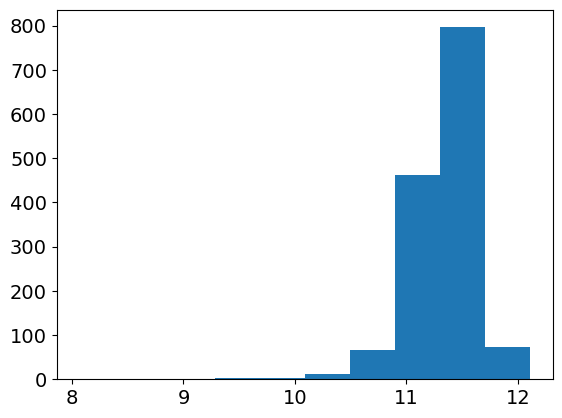

In [13]:
plt.hist(lrg_sample['logmass'])

(array([  7.,  28., 200., 252., 281., 241., 275.,  97.,  33.,   4.]),
 array([0.04345881, 0.17451677, 0.30557473, 0.43663269, 0.56769065,
        0.6987486 , 0.82980656, 0.96086452, 1.09192248, 1.22298044,
        1.3540384 ]),
 <BarContainer object of 10 artists>)

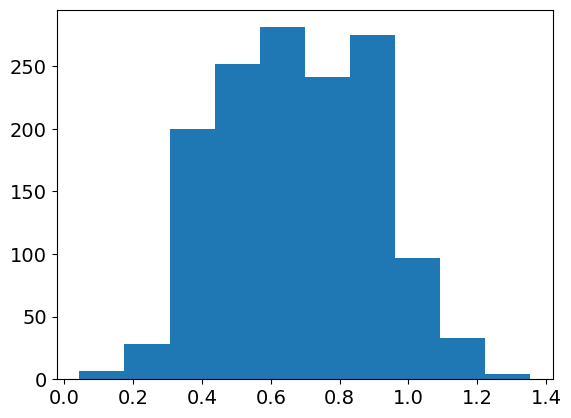

In [14]:
plt.hist(lrg_sample['Z'])

In [16]:
zmax = 10.
thetaE = 1.

zS = []

for lrg in lrg_sample:
    zS_max = get_max_zS(lrg['logmass'], lrg['Z'], zmax, thetaE)
    zS.append(zS_max)
    
zStab = Table()
zStab['max zS'] = zS

In [17]:
lrg_sample = hstack([lrg_sample, zStab])

Text(0, 0.5, 'maximum $z_S$')

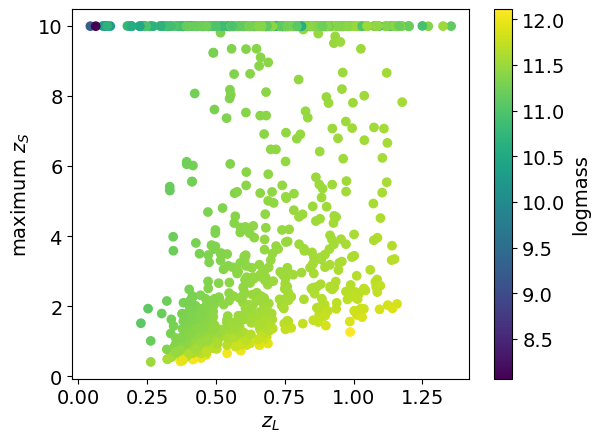

In [18]:
plt.scatter(lrg_sample['Z'], lrg_sample['max zS'], c=lrg_sample['logmass'])
plt.colorbar(label='logmass')
plt.xlabel('$z_L$')
plt.ylabel('maximum $z_S$')

### get spectra & match
get the spectra of our LRGs, and the spectra, redshifts, and targetids of a randomly chosen galaxy in the redshift range in the same healpixel

In [19]:
max_resamples = 10

ids = []
zs = []
waves = []
fluxes = []
matchids = []
matchzs = []
matchfluxes = []

for hpix in np.unique(lrg_sample['HEALPIX']):
    lrgs_in_hpix = lrg_sample[lrg_sample['HEALPIX'] == hpix]
    
    for program in np.unique(lrgs_in_hpix['PROGRAM']):
        lrgs_in_hpix_program = lrgs_in_hpix[lrgs_in_hpix['PROGRAM'] == program]
        digits = int(np.log10(hpix))+1
        first = 0

        if digits <= 4:
            first = hpix // 10 ** (int(np.log10(hpix)) - 2 + 1)
        else:
            first = hpix // 10 ** (int(np.log10(hpix)) - 3 + 1)

        spectra = read_spectra(f'/global/cfs/cdirs/desi/spectro/redux/{redux}/healpix/main/{program}/{first}/{hpix}/spectra-main-{program}-{hpix}.fits')
        coadds = coadd_cameras(spectra)
        redshifts = Table.read(f'/global/cfs/cdirs/desi/spectro/redux/{redux}/healpix/main/{program}/{first}/{hpix}/redrock-main-{program}-{hpix}.fits', 
                               'REDSHIFTS')
        print(hpix)

        for lrg in lrgs_in_hpix_program:
            select = np.equal(coadds.fibermap['TARGETID'], lrg['TARGETID'])
            
            wave = coadds.wave['brz']
            flux = coadds.flux['brz'][select][0]

            # use the redshifts to get a match ID and redshifts
            select = np.logical_and(redshifts['Z'] > lrg['Z'], redshifts['Z'] <= lrg['max zS'])
            match_candidates = redshifts[select]
            select = np.equal(match_candidates['ZWARN'], 0)
            match_candidates = match_candidates[select]

            select = np.greater(match_candidates['DELTACHI2'], 25)
            match_candidates = match_candidates[select]

            select = np.less(match_candidates['ZERR'], (1+match_candidates['Z'])*0.003)
            match_candidates = match_candidates[select]

            #if len(match_candidates) == 0:
                # if match not found (we'll cleanup later)
                #matchids.append(0)
                #matchzs.append(0.)
                #matchfluxes.append(np.zeros_like(coadds.wave['brz']))
            if len(match_candidates) != 0:
                # if match is found
                # update for resampling
                times_resampled = 0
                while times_resampled < max_resamples:
                    ids.append(lrg['TARGETID'])
                    zs.append(lrg['Z'])
                    waves.append(wave)
                    fluxes.append(flux)

                    idx = np.random.randint(0, len(match_candidates))
                    matchids.append(match_candidates['TARGETID'][idx])
                    matchzs.append(match_candidates['Z'][idx])

                    # get the matching spectrum
                    select = np.equal(coadds.fibermap['TARGETID'], match_candidates['TARGETID'][idx])
                    matchflux = coadds.flux['brz'][select][0]
                    matchfluxes.append(matchflux)

                    times_resampled += 1

idt = Table()
idt['TARGETID'] = ids
zt = Table()
zt['Z'] = zs
wavet = Table()
wavet['wave'] = waves
fluxt = Table()
fluxt['flux'] = fluxes
matchidt = Table()
matchidt['match targetid'] = matchids
matchzt = Table()
matchzt['match z'] = matchzs
matchfluxt = Table()
matchfluxt['match flux'] = matchfluxes

lrg_sample = hstack([idt, zt, wavet, fluxt, matchidt, matchzt, matchfluxt])
lrg_sample

INFO:spectra.py:291:read_spectra: iotime 0.630 sec to read spectra-main-bright-8284.fits at 2023-08-08T11:56:25.322053
8284
INFO:spectra.py:291:read_spectra: iotime 1.187 sec to read spectra-main-dark-8284.fits at 2023-08-08T11:56:29.327214
8284
INFO:spectra.py:291:read_spectra: iotime 0.548 sec to read spectra-main-bright-8321.fits at 2023-08-08T11:56:36.274065
8321
INFO:spectra.py:291:read_spectra: iotime 0.706 sec to read spectra-main-dark-8321.fits at 2023-08-08T11:56:39.691264
8321
INFO:spectra.py:291:read_spectra: iotime 1.003 sec to read spectra-main-bright-31210.fits at 2023-08-08T11:56:46.336086
31210
INFO:spectra.py:291:read_spectra: iotime 1.215 sec to read spectra-main-dark-31210.fits at 2023-08-08T11:56:50.739525
31210
INFO:spectra.py:291:read_spectra: iotime 0.670 sec to read spectra-main-bright-32331.fits at 2023-08-08T11:56:58.101279
32331
INFO:spectra.py:291:read_spectra: iotime 1.147 sec to read spectra-main-dark-32331.fits at 2023-08-08T11:57:02.381611
32331
INFO:spe

TARGETID,Z,wave,flux,match targetid,match z,match flux
int64,float64,float64[7781],float64[7781],int64,float64,float64[7781]
39628047023868020,0.5114493083894697,3600.0 .. 9824.000000000524,-8.577921867370605 .. 1.9594796895980835,39628029189689040,0.5765734959195883,-0.734148383140564 .. 2.2732996940612793
39628047023868020,0.5114493083894697,3600.0 .. 9824.000000000524,-8.577921867370605 .. 1.9594796895980835,39628029185494862,0.5308258152643499,18.588102340698242 .. 1.4075820446014404
39628047023868020,0.5114493083894697,3600.0 .. 9824.000000000524,-8.577921867370605 .. 1.9594796895980835,39628035133014650,0.611313028688115,0.8016698956489563 .. 1.6317657232284546
39628047023868020,0.5114493083894697,3600.0 .. 9824.000000000524,-8.577921867370605 .. 1.9594796895980835,39628035141405727,0.5168250995198554,5.111670017242432 .. 1.746995210647583
39628047023868020,0.5114493083894697,3600.0 .. 9824.000000000524,-8.577921867370605 .. 1.9594796895980835,39628029189689040,0.5765734959195883,-0.734148383140564 .. 2.2732996940612793
39628047023868020,0.5114493083894697,3600.0 .. 9824.000000000524,-8.577921867370605 .. 1.9594796895980835,39628029185494862,0.5308258152643499,18.588102340698242 .. 1.4075820446014404
39628047023868020,0.5114493083894697,3600.0 .. 9824.000000000524,-8.577921867370605 .. 1.9594796895980835,39628035133014650,0.611313028688115,0.8016698956489563 .. 1.6317657232284546
39628047023868020,0.5114493083894697,3600.0 .. 9824.000000000524,-8.577921867370605 .. 1.9594796895980835,39628035133014650,0.611313028688115,0.8016698956489563 .. 1.6317657232284546
39628047023868020,0.5114493083894697,3600.0 .. 9824.000000000524,-8.577921867370605 .. 1.9594796895980835,39628029189689040,0.5765734959195883,-0.734148383140564 .. 2.2732996940612793


## simulate lenses
take the sum of the fluxes weighted by $\alpha$ in the range \[0.5, 0.8\], randomly chosen

In [21]:
## weighted sum the fluxes together
alphas = []
sumfluxes = []

for lrg in lrg_sample:
    alpha = np.random.uniform(0.5, 0.8)
    sumflux = alpha*lrg['flux'] + (1-alpha)*lrg['match flux']
    alphas.append(alpha)
    sumfluxes.append(sumflux)

alphast = Table()
alphast['alpha'] = alphas
sumfluxt = Table()
sumfluxt['summed flux'] = sumfluxes

lrg_sample = hstack([lrg_sample, alphast, sumfluxt])

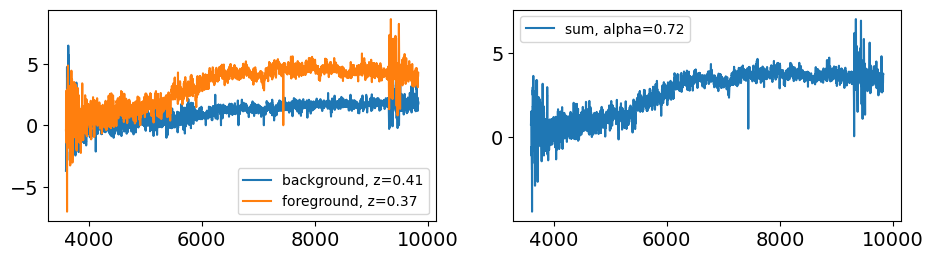

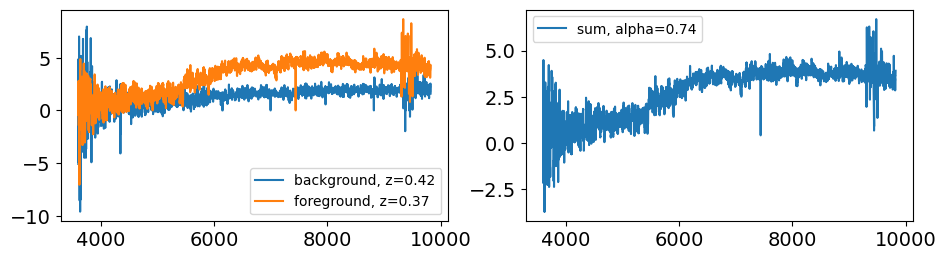

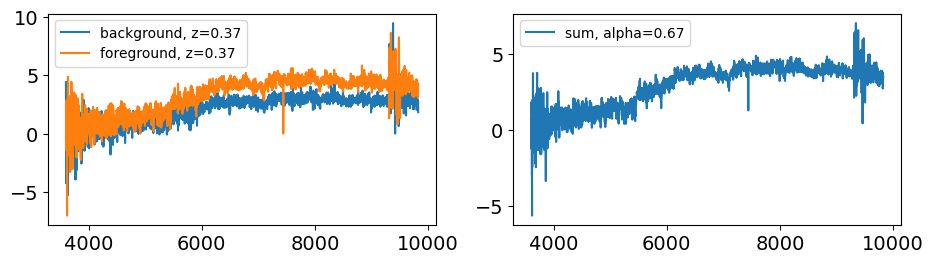

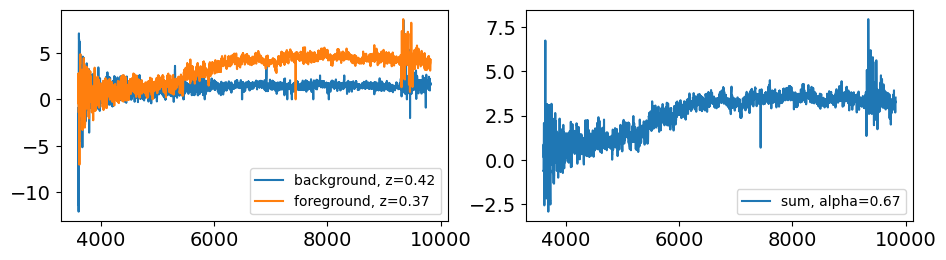

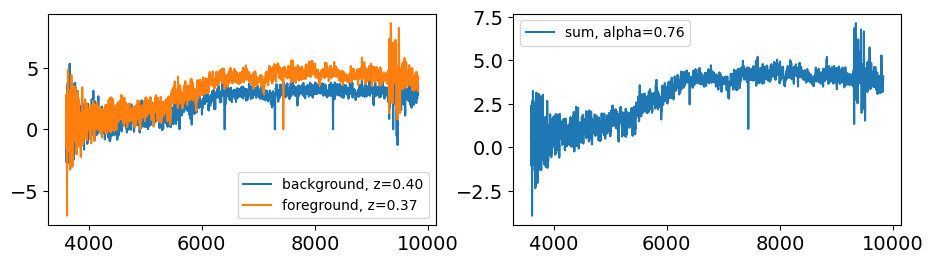

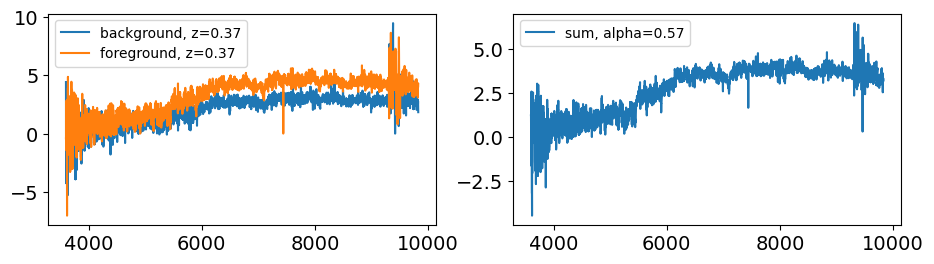

In [22]:
from scipy.ndimage import median_filter
for lrg in lrg_sample[40:46]:
    sumflux = lrg['summed flux']
    fig, ax = plt.subplots(1,2, figsize=(11,2.75))
    filtflux = median_filter(sumflux, 7)
    ax[1].plot(lrg['wave'], filtflux, label='sum, alpha={0:.2f}'.format(lrg['alpha']))
    ax[1].legend(fontsize="10")
    
    mfiltflux = median_filter(lrg['match flux'], 7)
    ax[0].plot(lrg['wave'], mfiltflux, label='background, z={0:.2f}'.format(lrg['match z']))
    filtflux = median_filter(lrg['flux'], 7)
    ax[0].plot(lrg['wave'], filtflux, label='foreground, z={0:.2f}'.format(lrg['Z']))
    ax[0].legend(fontsize="10")

In [23]:
#write our results to a fits file
lrg_sample.write('sim-lenses-10000-zonly.fits', format='fits')

In [ ]:
matchids = []
matchzs = []

for lrg in lrg_sample:
    digits = int(np.log10(lrg['HEALPIX']))+1
    first = 0

    if digits <= 4:
        first = lrg['HEALPIX'] // 10 ** (int(np.log10(lrg['HEALPIX'])) - 2 + 1)
    else:
        first = lrg['HEALPIX'] // 10 ** (int(np.log10(lrg['HEALPIX'])) - 3 + 1)

    program = lrg['PROGRAM']
    hpix = lrg['HEALPIX']
    redshifts = Table.read(f'/global/cfs/cdirs/desi/spectro/redux/{redux}/healpix/main/{program}/{first}/{hpix}/redrock-main-{program}-{hpix}.fits', 
                           'REDSHIFTS')
    
    select = np.logical_and(redshifts['Z'] > lrg['Z'], redshifts['Z'] <= lrg['max zS'])
    match_candidates = redshifts[select]
    select = np.equal(match_candidates['ZWARN'], 0)
    match_candidates = match_candidates[select]

    select = np.greater(match_candidates['DELTACHI2'], 25)
    match_candidates = match_candidates[select]

    select = np.less(match_candidates['ZERR'], (1+match_candidates['Z'])*0.003)
    match_candidates = match_candidates[select]
    
    idx = np.random.randint(0, len(match_candidates))
    matchids.append(match_candidates['TARGETID'][idx])
    matchzs.append(match_candidates['Z'][idx])
    
matchidt = Table()
matchidt['match targetid'] = matchids
matchzt = Table()
matchzt['match z'] = matchzs

lrg_sample = hstack([lrg_sample, matchidt, matchzt])
lrg_sample

In [ ]:
lrg_sample

In [ ]:
waves = []
fluxes = []

for lrg in lrg_sample:
    digits = int(np.log10(lrg['HEALPIX']))+1
    first = 0
    
    if digits <= 4:
        first = lrg['HEALPIX'] // 10 ** (int(np.log10(lrg['HEALPIX'])) - 2 + 1)
    else:
        first = lrg['HEALPIX'] // 10 ** (int(np.log10(lrg['HEALPIX'])) - 3 + 1)
        
    program = lrg['PROGRAM']
    hpix = lrg['HEALPIX']
    
    spectra = read_spectra(f'/global/cfs/cdirs/desi/spectro/redux/{redux}/healpix/main/{program}/{first}/{hpix}/spectra-main-{program}-{hpix}.fits')
    coadds = coadd_cameras(spectra)
    
    select = np.where(coadds.fibermap['TARGETID'] == lrg['match targetid'])
    wave = coadds.wave['brz']
    flux = coadds.flux['brz'][select][0]
    
    waves.append(wave)
    fluxes.append(flux)

    
wavet = Table()
wavet['match wave'] = waves
fluxt = Table()
fluxt['match flux'] = fluxes

lrg_sample = hstack([lrg_sample, wavet, fluxt])

In [ ]:
from scipy.ndimage import median_filter
for lrg in lrg_sample[0:10]:
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    filtflux = median_filter(lrg['flux'], 7)
    ax.plot(lrg['wave'], filtflux)
    mfiltflux = median_filter(lrg['match flux'], 7)
    ax.plot(lrg['match wave'], mfiltflux)

In [ ]:
for lrg in lrg_sample[0:10]:
    sumflux = lrg['flux'] + lrg['match flux']
    fig, ax = plt.subplots(1,2, figsize=(11,2.75))
    filtflux = median_filter(sumflux, 7)
    ax[1].plot(lrg['wave'], filtflux)

    filtflux = median_filter(lrg['flux'], 7)
    ax[0].plot(lrg['wave'], filtflux)
    mfiltflux = median_filter(lrg['match flux'], 7)
    ax[0].plot(lrg['match wave'], mfiltflux)
    